In [2]:
import numpy as np 

In [3]:
from scipy.optimize import curve_fit
from scipy.constants import N_A

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

Matplotlib is building the font cache; this may take a moment.


In [5]:
import itertools

In [6]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [7]:
import mdtraj as md

# Dilute boxes

In [39]:
def fix_gr(g_r, r, box):
    """
    Analytical fix to the radial distribution function

    Parameters
    ----------
    g_r : array
        Radial distribution function
    r : array
        Radial distance
    box : float
        Box size

    Returns
    -------
    """



def calcB22(g_r, r):
    """
    Calculate the second virial coefficient from the radial distribution function
    
    Parameters
    ----------
    g_r : array
        Radial distribution function
    r : array
        Radial distance
    
    Returns
    -------
    B22 : float
        Second virial coefficient in nm^3
    """
    return -2*np.pi*np.trapz((g_r -1)*r**2, x=r)

def calc_pb(distances, cut=None, log=True, plot=True):
    """ArithmeticError
    Calculate the bound fraction from the pairsiwe distances
    """
    if log: 
        hist, bin_edges = np.histogram(np.log10(np.concatenate(distances)), \
                density=True, bins=np.linspace(-0.5,1.25,nbins))
    else:
        hist, bin_edges = np.histogram(np.concatenate(distances), \
                density=True, bins=np.linspace(0,10,nbins))
        
    bin_centers = np.array([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(nbins-1)])
    if plot: 
        fig, ax = plt.subplots()
        ax.plot(bin_centers, hist)
        ax.axvline(cut, c='k', ls='--')
        xlabel = '$\log10(r)$' if log else '$r$ [nm]'
        ax.set_xlabel(xlabel)
        ylabel = '$P(\log(r)$)' if log else '$P(r)$'
        ax.set_ylabel(ylabel)
        ax.set_yscale('log')
        ax.set_ylim(5e-4, 10)
        plt.tight_layout()

    # Calculate the bound fraction
    ibound = np.argmin(np.abs(bin_centers - log_rcut))
    p_bound = np.trapz(hist[:ibound], dx=bin_centers[1]-bin_centers[0])

    return p_bound

def calc_kd(pb, V):
    return (1 - pb)**2/(V*N_A*pb)*1e24

def calc_kd_fromB22(pb, V, B22):
    return 1./(N_A*pb*(V - 2*B22))*1e24

def calc_kd_fromB22_approx(B22):
    """
    Calculate the dissociation constant from the second virial coefficient
    using the approximate expression: 
    B22 = 1/(2*N_A*Kd)

    Parameters
    ----------
    B22 : float
        Second virial coefficient in nm^3

    Returns
    -------
    Kd : float
        Dissociation constant in M
    """
    conversion = 1e-24
    return -1./(2*N_A*B22*conversion)

B22 = -1.132 nm^3
K_d = 0.733 M
p_b = 0.000


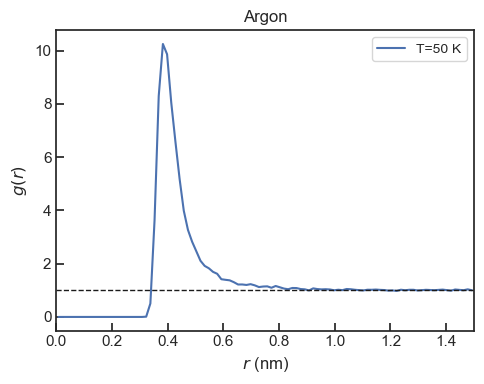

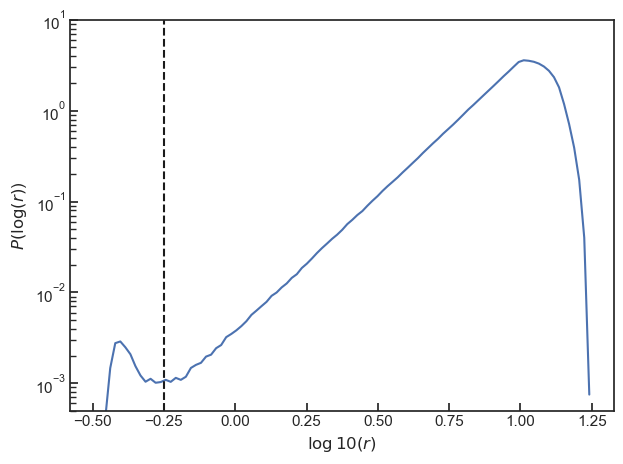

In [ ]:
nbins = 100
log_rcut = -0.25
fig, ax = plt.subplots(figsize=(5,4))

system = "argon"
t = 50
dcd = "data/%s_n50_L20_T%g_prod.dcd"%(system, t)
pdb = "data/%s_n50_L20_T%g_final.pdb"%(system, t)
try:
    # load trajectory
    traj = md.load_dcd(dcd, top=pdb, stride=1)

    # calculate rdf
    bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(50), 2)), \
                       r_range=[0,1.5], n_bins=nbins)
    ax.plot(bins, g_r, label='T=%g K'%t)
    
    # compute B22 from rdf 
    B22 = calcB22(g_r, bins)
    print ("B22 = %.3f nm^3"%B22)

    # compute approximate form of Kd from B22
    Kd_approx = calc_kd_fromB22_approx(B22)
    print ("K_d = %.3f M"%Kd_approx)

    # compute pairwise distances
    distances = md.compute_distances(traj, \
                    atom_pairs=list(itertools.combinations(range(20), 2)))

    # estimate population bound from histogram
    p_bound = calc_pb(distances, cut=log_rcut, log=True, plot=True)
    print ("p_b = %.3e"%p_bound)

except Exception as e:
    print (e)

ax.axhline(1,0,2,ls='dashed', lw=1, color='k')
ax.set_xlim(0.0,1.5)
ax.set_xlabel('$r$ (nm)')
ax.set_ylabel(r'$g(r)$')
ax.legend(loc=1,ncols=2, fontsize=10)
ax.set_title(system.capitalize())
fig.tight_layout()

No such file: data/argon_n50_L20_T10_final.pdb


/var/folders/w_/6y6c02w52ydcq3xnpj_nt2tr0000gn/T/ipykernel_95933/2727992347.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=1,ncols=2, fontsize=10)
/var/folders/w_/6y6c02w52ydcq3xnpj_nt2tr0000gn/T/ipykernel_95933/2727992347.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc=1,ncols=2, fontsize=10)


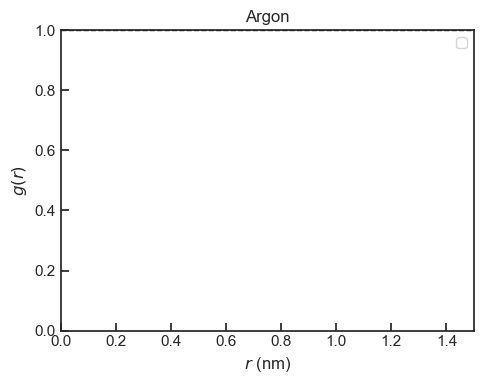

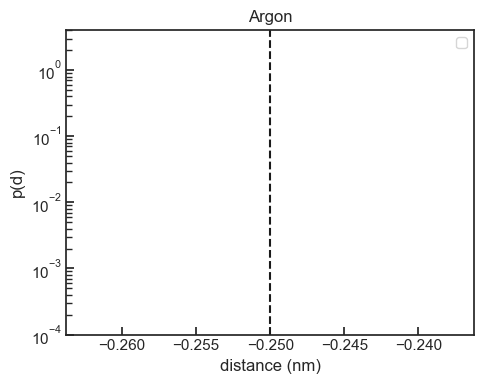

In [8]:
temps = range(10,190,10)
nbins = 150
log_rcut = -0.25

B22_all = {}
p_bound_all = {}

for system in ["neon", "argon", "krypton", "xenon", "methane"]:
    B22 = []; p_bound = []
    fig, ax = plt.subplots(figsize=(5,4))
    fig2, ax2 = plt.subplots(figsize=(5,4))
    for t in temps:
        dcd = "data/%s_n50_L20_T%g_prod.dcd"%(system, t)
        pdb = "data/%s_n50_L20_T%g_final.pdb"%(system, t)
        try:
            traj = md.load_dcd(dcd, top=pdb, stride=2)
            bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(50), 2)), \
                               r_range=[0,1.5], n_bins=nbins)
            ax.plot(bins, g_r, label='T=%g K'%t)
            B22.append([t, -2*np.pi*np.trapz((g_r -1)*bins**2, x=bins)])

            distances = md.compute_distances(traj, \
                                atom_pairs=list(itertools.combinations(range(20), 2)))
            hist, bin_edges = np.histogram(np.log10(np.concatenate(distances)), \
                                density=True, bins=np.linspace(-0.5,1.25,nbins))
            bin_centers = np.array([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(nbins-1)])
            ax2.plot(bin_centers, hist, label='T=%g K'%t)
            ibound = np.argmin(np.abs(bin_centers - log_rcut))
            p_bound.append([t, np.trapz(hist[:ibound], dx=bin_centers[1]-bin_centers[0])])
        except Exception as e:
            print (e)

    B22_all[system] = np.array(B22)
    p_bound_all[system] = np.array(p_bound)

    ax.axhline(1,0,2,ls='dashed', lw=1, color='k')
    ax.set_xlim(0.0,1.5)
    ax.set_xlabel('$r$ (nm)')
    ax.set_ylabel(r'$g(r)$')
    ax.legend(loc=1,ncols=2, fontsize=10)
    ax.set_title(system.capitalize())
    fig.tight_layout()

    ax2.axvline(log_rcut, ls='--', color='k')
    ax2.set_yscale('log')
    ax2.set_xlabel('distance (nm)')
    ax2.set_ylabel('p(d)')
    #ax2.set_xlim(0, 17)
    ax2.set_ylim(1e-4, 4)
    ax2.legend(loc=1,ncols=2, fontsize=10)
    ax2.set_title(system.capitalize())
    fig2.tight_layout()
    break

Text(0, 0.5, '$K_D$ (M$^{-1}$)')

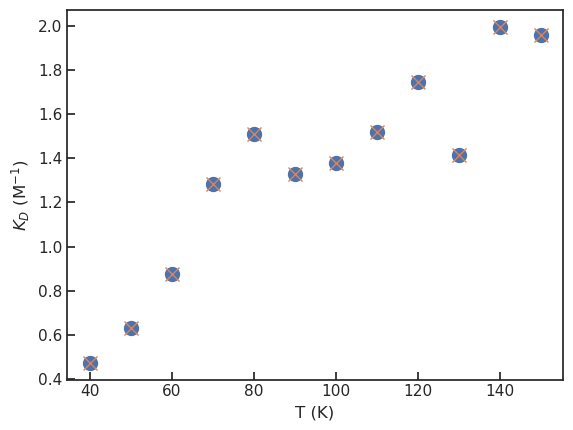

In [128]:
plt.plot(temps, calc_kd(np.array(pb), 20**3), 'o', ms=10)
plt.plot(temps, calc_kd_fromB22(np.array(pb), 20**3, np.array(B22)), 'x', ms=10)
plt.xlabel('T (K)')
#plt.xlabel('$p_{bound}$')
plt.ylabel('$K_D$ (M$^{-1}$)')